## **Klasifikasi Sinyal ECG Menggunakan CNN 1D**

Notebook ini berisi contoh penerapan pembelajaran mesin untuk mengenali pola pada sinyal ECG (Electrocardiogram).  
Sinyal ECG digunakan untuk menggambarkan aktivitas listrik jantung, dan dari pola tersebut kita dapat mengetahui apakah detak jantung seseorang normal atau mengalami gangguan tertentu.

Tujuan utama dari proyek ini adalah membuat model deep learning berbasis CNN 1D yang mampu mengklasifikasikan sinyal ECG ke dalam beberapa kategori detak jantung berdasarkan data dari MIT-BIH Arrhythmia Dataset.

---

## **Studi Kasus dan Model**

Pada studi kasus ini, kita akan melakukan klasifikasi sinyal ECG menggunakan model CNN satu dimensi (1D Convolutional Neural Network).  
Model CNN 1D dipilih karena cocok untuk data berurutan seperti sinyal, di mana urutan dan bentuk gelombang memiliki arti penting.

---

## **Kelas yang Diklasifikasikan**

Model akan dilatih untuk mengenali beberapa jenis sinyal detak jantung, misalnya:
1. Normal Beat (detak jantung normal)
2. Premature Ventricular Contraction (detak dari ventrikel)
3. Atrial Premature Beat (detak dari atrium)
4. Left Bundle Branch Block (gangguan penghantaran sinyal bagian kiri)
5. Right Bundle Branch Block (gangguan penghantaran sinyal bagian kanan)

Jenis kelas ini bisa berbeda tergantung subset data yang digunakan dari MIT-BIH Arrhythmia Dataset.

---

## **Dataset**

Dataset yang digunakan adalah MIT-BIH Arrhythmia Dataset, yaitu kumpulan data sinyal ECG yang direkam dari beberapa pasien dengan berbagai kondisi jantung.
Download dataset dari kaggle berformat .zip kemudian ekstrak dan simpan dataset di folder lokal komputer anda.

link download dataset: [CNN1D ECG Classification Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)

---

## **Tahapan yang Akan Dilalui**

Dalam notebook ini, kita akan melewati beberapa tahapan utama agar model dapat bekerja dengan baik, yaitu:

1. **Import Library**  
   Memanggil berbagai library yang digunakan dalam proyek

2. **Load Dataset**  
   Mengimport dataset yang telah didownload dikaggle

3. **Preprocessing data**  
   Membersihkan dan menyiapkan sinyal agar dapat dibaca oleh model. Termasuk normalisasi nilai, mengubah bentuk data, dan mengonversinya menjadi tensor.

4. **Membuat DataLoader**  
   Membagi data menjadi beberapa bagian kecil (batch) agar proses pelatihan lebih cepat dan stabil.

5. **Membangun arsitektur CNN 1D**  
   Menentukan lapisan-lapisan pada jaringan CNN yang akan memproses sinyal ECG.

6. **Melatih model**  
   Menjalankan proses training untuk mengajarkan model mengenali pola dari data.

7. **Evaluasi model**  
   Menguji seberapa baik model bekerja dalam mengklasifikasikan sinyal ECG yang belum pernah dilihat.

8. **Visualisasi hasil**  
   Melihat grafik loss dan performa model selama proses pelatihan.

9. **Inferensi Model**  
   Melihat seberapa akurat model yang telah dilatih dalam mengklasifikasi sinyal dengan dataset yang berbeda.

---

## **Tujuan Akhir**

Melalui notebook ini, mahasiswa diharapkan dapat memahami:
- Bagaimana data sinyal diproses sebelum digunakan untuk pelatihan.  
- Cara kerja CNN 1D dalam mengenali pola pada sinyal.  
- Bagaimana melatih dan mengevaluasi model klasifikasi berbasis deep learning.  

Notebook ini juga bisa dijadikan dasar untuk pengembangan model lain pada jenis sinyal berbeda, seperti sinyal suara, EEG, atau data sensor lainnya.

Link notebook google collab : [CNN1D_ECG_Classification.ipynb](https://colab.research.google.com/drive/1l5vC-f3LDtFKthh1NY_TRmb08Xqp2fZ0#scrollTo=nuC6uN_JUtne)

## **1. Import Library**
Pada tahap ini, kita akan memanggil berbagai library yang digunakan dalam proyek:
- **NumPy** → manipulasi data numerik (array dan matriks).  
- **Matplotlib** → visualisasi sinyal dan grafik hasil pelatihan.  
- **PyTorch** → membangun dan melatih model deep learning.  
- **torch.nn** → menyediakan layer neural network seperti `Conv1d`, `ReLU`, dan `Linear`.  
- **torch.utils.data** → untuk membuat `DataLoader` agar proses training lebih efisien.

In [1]:
# =========================================================
# Pendahuluan
# =========================================================
# CNN 1D untuk Klasifikasi Sinyal ECG

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


## **2. Load Dataset**
Dataset ECG (MIT-BIH Arrhythmia) digunakan untuk mendeteksi berbagai jenis aritmia jantung.  
Sinyal ECG direkam dalam bentuk gelombang waktu yang perlu diolah terlebih dahulu agar bisa dimasukkan ke model CNN.

Langkah pada bagian ini:
1. Memuat data dari file `.csv` atau sumber lain.  
2. Mengecek bentuk (shape) data dan label.  
3. Melakukan eksplorasi awal (opsional) seperti menampilkan sinyal contoh.


In [2]:
# =========================================================
# Upload Dataset dari Lokal
# =========================================================
# Upload manual dua file: mitbih_train.csv dan mitbih_test.csv
from google.colab import files

print("Silakan upload dua file berikut:")
print("1. mitbih_train.csv")
print("2. mitbih_test.csv")

uploaded = files.upload()

data = pd.read_csv("mitbih_train.csv", header=None)
test = pd.read_csv("mitbih_test.csv", header=None)

print("Data train:", data.shape)
print("Data test :", test.shape)


Silakan upload dua file berikut:
1. mitbih_train.csv
2. mitbih_test.csv


Saving mitbih_test.csv to mitbih_test.csv
Saving mitbih_train.csv to mitbih_train.csv
Data train: (87554, 188)
Data test : (21892, 188)


## **3. Tahapan Preprocessing**
Sebelum data sinyal digunakan untuk pelatihan, kita perlu melalui beberapa tahap preprocessing agar formatnya sesuai dengan kebutuhan model.

Terdapat **tiga tahap utama preprocessing**:
1. **Normalisasi**  
   - Menyamakan skala nilai sinyal (biasanya 0–1) agar tidak ada perbedaan skala ekstrem antar sampel.  
2. **Reshaping dan Splitting**  
   - Mengubah bentuk data menjadi format `[batch_size, channel, sequence_length]` agar cocok untuk CNN 1D.  
   - Memisahkan dataset menjadi **training set** dan **testing set** dengan rasio tertentu.  
3. **Konversi ke Tensor**  
   - Mengubah data dari bentuk NumPy array menjadi Tensor PyTorch agar bisa diproses oleh GPU/CPU.

Setelah tahap ini, data siap dimasukkan ke DataLoader untuk pelatihan model.


In [3]:
# =========================================================
# Preprocessing Data
# =========================================================
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

# Normalisasi agar nilainya di kisaran 0-1
X = X / np.max(X)
X_test = X_test / np.max(X_test)

# Ubah ke format (samples, channels, length)
X = np.expand_dims(X, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Split train-validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Ubah ke tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print("Training data:", X_train.shape, y_train.shape)


Training data: torch.Size([70043, 1, 187]) torch.Size([70043])


## **4. Data Loader**
`DataLoader` digunakan untuk membagi data menjadi batch kecil agar proses pelatihan berjalan efisien dan stabil.
Selain itu, DataLoader juga membantu melakukan **shuffle** pada data agar model tidak menghafal urutan input.

Parameter penting:
- `batch_size`: jumlah data dalam satu batch.  
- `shuffle=True`: mengacak urutan data setiap epoch.

In [4]:
# =========================================================
# DataLoader
# =========================================================
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ECGDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(ECGDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(ECGDataset(X_test, y_test), batch_size=32)


## **5. Arsitektur Model CNN 1D**
Model CNN 1D yang digunakan terdiri dari beberapa lapisan utama:
1. **Convolutional Layer (Conv1D)** – mengekstraksi pola lokal dari sinyal ECG.  
2. **Activation Function (ReLU)** – memperkenalkan non-linearitas agar model dapat belajar hubungan kompleks.  
3. **Pooling Layer (MaxPooling1D)** – mengurangi dimensi data dan mencegah overfitting.  
4. **Fully Connected Layer (Linear)** – mengubah hasil ekstraksi fitur menjadi prediksi kelas.  
5. **Softmax Output** – menghasilkan probabilitas untuk setiap kelas aritmia.

Struktur ini cukup ringan namun efektif untuk dataset sinyal.


In [5]:
# =========================================================
# Arsitektur Model CNN 1D
# =========================================================
class CNN1D(nn.Module):
    def __init__(self, input_length=187, num_classes=5):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.3)

        # Hitung dimensi flatten otomatis
        with torch.no_grad():
            x = torch.zeros(1, 1, input_length)
            x = self.pool1(torch.relu(self.conv1(x)))
            x = self.pool2(torch.relu(self.conv2(x)))
            flatten_dim = x.shape[1] * x.shape[2]

        self.fc1 = nn.Linear(flatten_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

signal_length = X_train.shape[2]
model = CNN1D(input_length=signal_length, num_classes=5).to(device)
print(model)


CNN1D(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=2944, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


## **6. Proses Pelatihan Model**

Sebelum proses pelatihan dimulai, terlebih dahulu ditetapkan beberapa **parameter penting** yang akan memengaruhi kinerja model:

- **Learning Rate (lr)** → menentukan seberapa besar langkah pembaruan bobot pada setiap iterasi.  
- **Epochs** → menunjukkan berapa kali seluruh dataset dilalui selama proses pelatihan.  
- **Optimizer** → algoritma yang digunakan untuk memperbarui bobot, seperti *Adam* atau *Stochastic Gradient Descent (SGD)*.  
- **Loss Function** → fungsi yang mengukur seberapa jauh hasil prediksi model dari label sebenarnya.  
  Untuk kasus klasifikasi, umumnya digunakan `CrossEntropyLoss`.

Setelah parameter ditentukan, dilakukan proses **pelatihan model** dengan langkah-langkah berikut:

1. Mengambil data secara bertahap (*mini-batch*) dari `DataLoader`.  
2. Melakukan **forward pass** untuk menghasilkan prediksi dari data input.  
3. Menghitung **loss** berdasarkan selisih antara prediksi dan label aktual.  
4. Melakukan **backpropagation** agar model memperbarui bobotnya secara bertahap.  
5. Mencatat nilai *loss* di setiap epoch sebagai bahan evaluasi dan visualisasi.

Melalui beberapa siklus epoch, model akan belajar mengenali pola karakteristik sinyal ECG dan mampu membedakan antar kelas secara lebih akurat.

In [6]:
# =========================================================
# Training Model
# =========================================================
unique_classes = np.unique(y_train)
class_weights = compute_class_weight(
    'balanced', classes=unique_classes, y=y_train.numpy()
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Jika hanya satu kelas (misal dataset kecil hasil potongan)
if len(unique_classes) == 1:
    print("⚠️ Hanya ada 1 kelas dalam dataset. Training tidak bisa dilakukan untuk klasifikasi multi-class.")
    criterion = nn.CrossEntropyLoss()  # tanpa weight
else:
    criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 15
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for Xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validasi
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            val_outputs = model(Xv)
            val_loss += criterion(val_outputs, yv).item()

    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    print(f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 1/15: 100%|██████████| 2189/2189 [01:10<00:00, 30.92it/s]


Train Loss: 0.4943, Val Loss: 0.3154


Epoch 2/15: 100%|██████████| 2189/2189 [01:05<00:00, 33.60it/s]


Train Loss: 0.3204, Val Loss: 0.2728


Epoch 3/15: 100%|██████████| 2189/2189 [00:59<00:00, 36.85it/s]


Train Loss: 0.2757, Val Loss: 0.2481


Epoch 4/15: 100%|██████████| 2189/2189 [01:09<00:00, 31.68it/s]


Train Loss: 0.2373, Val Loss: 0.2365


Epoch 5/15: 100%|██████████| 2189/2189 [01:00<00:00, 36.29it/s]


Train Loss: 0.2101, Val Loss: 0.2124


Epoch 6/15: 100%|██████████| 2189/2189 [01:12<00:00, 30.36it/s]


Train Loss: 0.1955, Val Loss: 0.2449


Epoch 7/15: 100%|██████████| 2189/2189 [01:04<00:00, 33.85it/s]


Train Loss: 0.1751, Val Loss: 0.1957


Epoch 8/15: 100%|██████████| 2189/2189 [01:09<00:00, 31.39it/s]


Train Loss: 0.1593, Val Loss: 0.1925


Epoch 9/15: 100%|██████████| 2189/2189 [01:20<00:00, 27.28it/s]


Train Loss: 0.1532, Val Loss: 0.1959


Epoch 10/15: 100%|██████████| 2189/2189 [01:04<00:00, 34.09it/s]


Train Loss: 0.1391, Val Loss: 0.2069


Epoch 11/15: 100%|██████████| 2189/2189 [01:03<00:00, 34.64it/s]


Train Loss: 0.1350, Val Loss: 0.1795


Epoch 12/15: 100%|██████████| 2189/2189 [01:04<00:00, 34.05it/s]


Train Loss: 0.1207, Val Loss: 0.1951


Epoch 13/15: 100%|██████████| 2189/2189 [01:02<00:00, 35.04it/s]


Train Loss: 0.1141, Val Loss: 0.1846


Epoch 14/15: 100%|██████████| 2189/2189 [01:16<00:00, 28.51it/s]


Train Loss: 0.1028, Val Loss: 0.1862


Epoch 15/15: 100%|██████████| 2189/2189 [00:51<00:00, 42.30it/s]


Train Loss: 0.0984, Val Loss: 0.1729


## **9. Evaluasi Model**
Evaluasi dilakukan pada data **testing set** yang belum pernah dilihat model sebelumnya.  
Langkah evaluasi:
1. Melakukan prediksi pada data uji.  
2. Menghitung **akurasi**, **precision**, **recall**, dan **F1-score**.  
3. (Opsional) Menampilkan **confusion matrix** untuk melihat distribusi prediksi tiap kelas.

Akurasi Test: 95.39%

 Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     18118
           1       0.51      0.86      0.64       556
           2       0.88      0.96      0.92      1448
           3       0.40      0.86      0.55       162
           4       0.97      0.99      0.98      1608

    accuracy                           0.95     21892
   macro avg       0.75      0.92      0.81     21892
weighted avg       0.97      0.95      0.96     21892



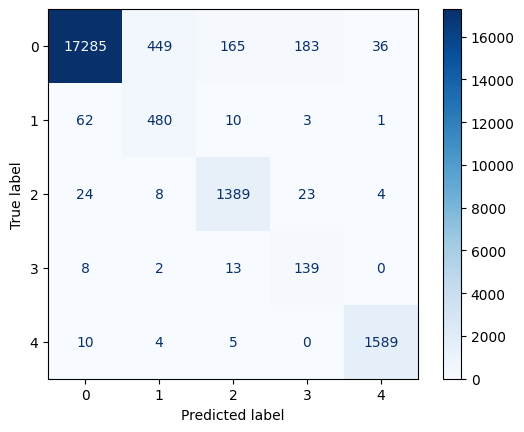

In [7]:
# =========================================================
# Evaluasi Model
# =========================================================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        outputs = model(Xb)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print(f"Akurasi Test: {acc*100:.2f}%")

print("\n Laporan Klasifikasi:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()


## **8. Visualisasi Hasil Pelatihan**
Setelah proses training selesai, dilakukan visualisasi terhadap:
- Grafik **training loss** per epoch.  
- (Opsional) Grafik **accuracy** jika dihitung setiap epoch.

Tujuannya adalah untuk melihat apakah model mengalami *convergence* (loss menurun stabil) dan tidak mengalami *overfitting*.


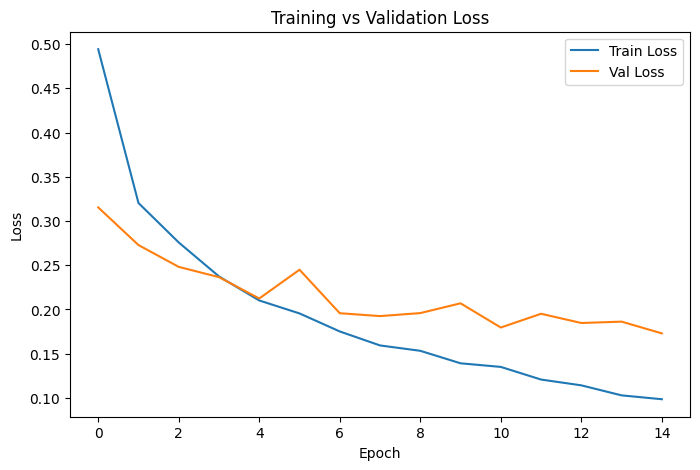

In [8]:
# =========================================================
# Visualisasi Loss
# =========================================================
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


## **11. Inferensi pada Sampel Tunggal**

Setelah model dilatih dan dievaluasi, langkah selanjutnya adalah menggunakannya untuk membuat prediksi pada data baru. Proses ini disebut **inferensi**. Jadi kita bisa melihat bagaimana hasil akurasi dari model yang sudah kita buat dan latih diawal.

Pada bagian ini, kita akan:
1. Mengambil satu sampel sinyal ECG acak dari *test set*.
2. Memasukkan sinyal tersebut ke dalam model yang sudah dilatih.
3. Melihat hasil prediksi kelas dari model beserta probabilitasnya.
4. Membandingkan hasil prediksi dengan label yang sebenarnya.
5. Memvisualisasikan sinyal yang diuji.

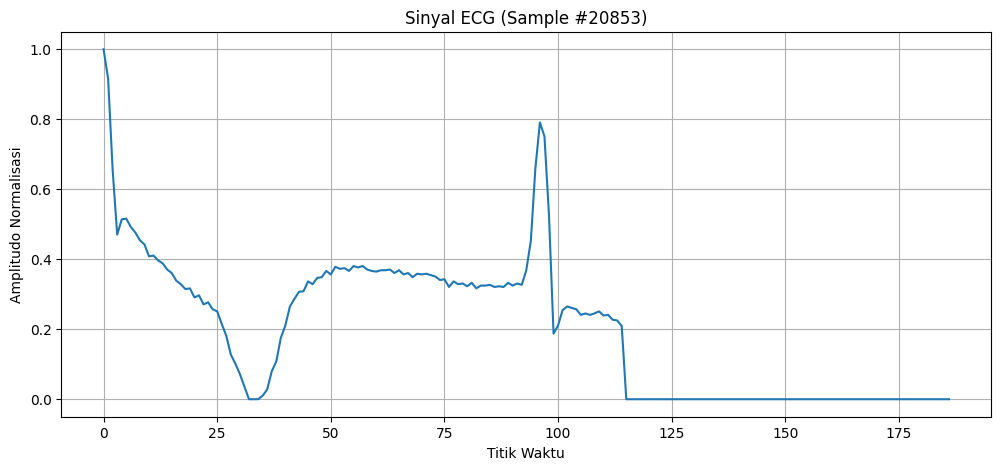

Sample Index: 20853
------------------------------
Label Sebenarnya: Unknown Beat (Q) (Indeks: 4)
Prediksi Model    : Unknown Beat (Q) (Indeks: 4)
------------------------------
Probabilitas Prediksi per Kelas:
  - Kelas 0 (Normal Beat (N)): 0.50%
  - Kelas 1 (Supraventricular Ectopic Beat (S)): 0.00%
  - Kelas 2 (Ventricular Ectopic Beat (V)): 1.43%
  - Kelas 3 (Fusion Beat (F)): 0.00%
  - Kelas 4 (Unknown Beat (Q)): 98.06%

Status: Prediksi BENAR


In [10]:
# =========================================================
# Inferensi pada Sampel Tunggal
# =========================================================

# Definisikan nama kelas sesuai dengan dataset
class_names = {
    0: 'Normal Beat (N)',
    1: 'Supraventricular Ectopic Beat (S)',
    2: 'Ventricular Ectopic Beat (V)',
    3: 'Fusion Beat (F)',
    4: 'Unknown Beat (Q)'
}

# Pilih sampel acak dari test set
sample_idx = np.random.randint(0, len(X_test))
sample_signal = X_test[sample_idx]
true_label_idx = y_test[sample_idx].item()

# Siapkan sinyal untuk input model (tambahkan batch dimension)
input_tensor = sample_signal.unsqueeze(0).to(device)

# Set model ke mode evaluasi
model.eval()

# Lakukan prediksi tanpa menghitung gradien
with torch.no_grad():
    output = model(input_tensor)
    # Konversi output logits ke probabilitas menggunakan softmax
    probabilities = torch.softmax(output, dim=1)
    # Dapatkan kelas dengan probabilitas tertinggi
    predicted_idx = torch.argmax(probabilities, dim=1).item()

# Dapatkan nama kelas dari hasil prediksi dan label asli
predicted_class = class_names[predicted_idx]
true_class = class_names[true_label_idx]

# Visualisasikan sinyal ECG
plt.figure(figsize=(12, 5))
plt.plot(sample_signal.squeeze().cpu().numpy())
plt.title(f"Sinyal ECG (Sample #{sample_idx})")
plt.xlabel("Titik Waktu")
plt.ylabel("Amplitudo Normalisasi")
plt.grid(True)
plt.show()

# Tampilkan hasil inferensi
print(f"Sample Index: {sample_idx}")
print("-" * 30)
print(f"Label Sebenarnya: {true_class} (Indeks: {true_label_idx})")
print(f"Prediksi Model    : {predicted_class} (Indeks: {predicted_idx})")
print("-" * 30)
print("Probabilitas Prediksi per Kelas:")
for i, prob in enumerate(probabilities.squeeze().cpu().numpy()):
    print(f"  - Kelas {i} ({class_names[i]}): {prob*100:.2f}%")

if predicted_idx == true_label_idx:
    print("\nStatus: Prediksi BENAR")
else:
    print("\nStatus: Prediksi SALAH")


## **Kesimpulan**
Pada notebook ini, kita telah belajar tahapan lengkap klasifikasi sinyal ECG:
1. Preprocessing (normalisasi, reshaping, konversi tensor).  
2. Pembuatan DataLoader untuk batch training.  
3. Pembangunan arsitektur CNN 1D.  
4. Pelatihan dan evaluasi model.  
5. Visualisasi hasil loss dan performa.

Dengan memahami tahapan ini, mahasiswa dapat mengembangkan model serupa untuk berbagai jenis sinyal digital lainnya seperti EMG, EEG, atau suara.